### Global imports

In [ ]:
!pip install dill

In [ ]:
import pandas as pd
import numpy as np
import functools as ft
import os.path
import os
import dill
from tqdm.notebook import tqdm
import random

In [ ]:
# Helper functions

# Converts a function whic operates on single elements, to a functioin that operates on lists
def mapc(f):
  def g(xs):
    return [f(x) for x in xs]
  return g

# Operator for function composition
def pipe(*fs):
  def g(x):
    for f in fs:
      x=f(x)
    return x
  return g

def joinu(*ws):
  return '_'.join(ws)

### Preprocessing and vectorization

#### Imports

In [ ]:
# !pip install transformers

In [ ]:
import nltk
import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

for dependency in ('wordnet', 'punkt','stopwords'):
    nltk.download(dependency)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Preprocess

In [ ]:
# Text cleaning function
def clean_text(text):
    if isinstance(text, str):
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = text.lower()
        return text
    else:
        return ''

# Tokenization function using NLTK
stop_words = set(stopwords.words('english'))
def tokenize_text(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

# Join list of strings with spaces
def join(ws):
  return ' '.join(ws)

# File name of the dataset
df_name = 'News_Category_Dataset_IS_course.json'
#df_name = './drive/MyDrive/IS2/News_Category_Dataset_IS_course.json'

# Initialize lemmatizer and stemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Test if "cache" exists else recompute
if os.path.exists('df'):
  with open('df','rb') as dfile:
    df = dill.load(dfile)
  with open('dfna','rb') as dfile:
    dfna = dill.load(dfile)
else:
  # Open file
  df = pd.read_json(df_name, lines=True)
  # Remove unnecesary columns
  dfna = df.copy()
  df = df.drop(columns=['link','authors','date'])
  # Clean colums for training
  for d in ['headline', 'short_description']:
    df[d+'_cleaned'] = df[d].apply(pipe(clean_text,
                                        tokenize_text,
                                        mapc(lemmatizer.lemmatize),
                                        mapc(stemmer.stem)
                                        ))
  df['data'] = df['headline_cleaned']+df['short_description_cleaned']
  dfna['data'] = df['data']
  # Remove invalid rows
  df = df.dropna()

  with open('df','wb') as dfile:
    dill.dump(df,dfile)
  with open('dfna','wb') as dfile:
    dill.dump(dfna,dfile)

In [ ]:
!pip install imblearn


Create balanced datasets (for evaluation and training purposes)

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling  import RandomOverSampler
import random

# Undersample
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(df, df['category'])

# Oversample
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(df, df['category'])
# To use only a subset
sample = np.array(random.sample(range(len(X_ros)),len(df)))
X_ros, y_ros = X_ros.iloc[sample], y_ros.iloc[sample]

Train test split

In [ ]:
from sklearn.model_selection import train_test_split

# Create the train test split
train,test = {},{}

# Create train, test splits for
# original dataset
trn,tst,train['orig_class'],test['orig_class'] = train_test_split(df, df['category'], test_size=0.2, random_state=42)
train['orig'],test['orig']=trn['data'],tst['data']

# undersampled dataset
trn_rus,tst_rus,train['rus_class'],test['rus_class'] = train_test_split(X_rus, y_rus, test_size=0.2, random_state=42)
train['rus'],test['rus']=trn_rus['data'],tst_rus['data']

# oversampled dataset
trn_ros,tst_ros,train['ros_class'],test['ros_class'] = train_test_split(X_ros, y_ros, test_size=0.2, random_state=42)
train['ros'],test['ros']=trn_ros['data'],tst_ros['data']

samples = ['orig','ros']#,'rus']

In [ ]:
len(trn_ros)

117324

#### Vectorization and scaling

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.decomposition import TruncatedSVD

w2v_vector_size = 100

# Function for converting words to vectors with the given word2vec model
def to_w2v(w2v):
  def f(tokens):
    return [w2v.wv[t] for t in tokens if t in w2v.wv]
  return f

# Function for computing the mean of a list of word2vec vectors
def avg_w2v(w2v):
  def f(tokens):
    sum,len = 0,0
    for token in tokens:
      if token in w2v.wv:
        sum += w2v.wv[token]
        len += 1
    return sum/len if len>0 else [0]*w2v_vector_size
  return f

vect = {}
bar = tqdm(total=len(samples)*5,desc='Progress')
for d in samples:
  # Vectorize text using TF-IDF vectorizer
  tfidfVectorizer = TfidfVectorizer(max_features=5000)
  vect[d+'_tfidf_vectorizer']  = tfidfVectorizer
  train[d+'_tfidf'] = tfidfVectorizer.fit_transform(train[d].apply(join))
  test[d+'_tfidf']  = tfidfVectorizer.transform(test[d].apply(join))
  bar.update()

  # Vectorize text using word2vec
  vect[d+'_w2v_vectorizer'] = Word2Vec(train[d], vector_size=w2v_vector_size,
                                  window=5, min_count=5, workers=4, epochs=10)
  bar.update()
  # Convert tokens to word2vec vectors
  train[d+'_w2v'] = train[d].apply(to_w2v(vect[d+'_w2v_vectorizer']))
  test[d+'_w2v']  =  test[d].apply(to_w2v(vect[d+'_w2v_vectorizer']))
  bar.update()
  # Compute the average of word2vec vectors
  train[d+'_avg_w2v'] = train[d].apply(avg_w2v(vect[d+'_w2v_vectorizer']))
  test[d+'_avg_w2v']  =  test[d].apply(avg_w2v(vect[d+'_w2v_vectorizer']))
  bar.update()

  # Scale average word2vec to a range [0,1]
  scaler = MinMaxScaler()
  vect[d+'_avg_w2v_scaler']  = scaler
  train[d+'_avg_w2v_scaled'] = scaler.fit_transform(np.stack(train[d+'_avg_w2v'].to_numpy()))
  test[d+'_avg_w2v_scaled']  = scaler.transform(np.stack(test[d+'_avg_w2v'].to_numpy()))
  bar.update()

Progress:   0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
test.keys()

dict_keys(['orig_class', 'orig', 'ros_class', 'ros', 'orig_tfidf', 'orig_w2v', 'orig_avg_w2v', 'orig_class_label', 'orig_avg_w2v_scaled', 'ros_tfidf', 'ros_w2v', 'ros_avg_w2v', 'ros_class_label', 'ros_avg_w2v_scaled'])

In [ ]:
# Functions used to "regularize" inputs to models

regularize={}
regularize['tfidf']=lambda table:np.asarray(table.todense())
regularize['avg_w2v_scaled']=lambda table: table
regularize['avg_w2v']=lambda table: np.stack(table.to_numpy())
regularize['tsvd']=lambda table:np.asarray(table)

### Exploratory data analysis

#### Imports

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram

#### General overview

In [ ]:
# Display general overview of the DataFrame
print(df.info())

# Create a sample
df_sample = df.sample(10000,random_state=42)

# Display basic statistics
print(df_sample.describe())

# Check the first few rows of the DataFrame
print(df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146655 entries, 0 to 148121
Data columns (total 6 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   headline                   146655 non-null  object
 1   category                   146655 non-null  object
 2   short_description          146655 non-null  object
 3   headline_cleaned           146655 non-null  object
 4   short_description_cleaned  146655 non-null  object
 5   data                       146655 non-null  object
dtypes: object(6)
memory usage: 7.8+ MB
None
              headline  category short_description  \
count            10000     10000             10000   
unique            9984        15              9171   
top     Sunday Roundup  POLITICS                     
freq                 4      2340               769   

                                         headline_cleaned  \
count                                               10000   
uniq

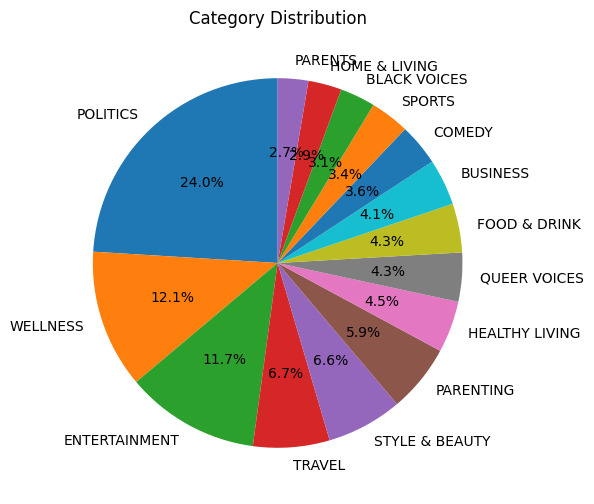

In [ ]:
# Plot a pie chart of category distribution
category_counts = df['category'].value_counts()
plt.figure(figsize=(10, 6))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Category Distribution')
plt.show()

#### Analysis of missing values

In [ ]:
# Check for missing values in the DataFrame
missing_values = dfna.isnull()

# Display the count of missing values for each column
print("\nNumber of Missing Values:")
print(missing_values.sum())

# Count overlapping
print((dfna['headline'].isnull() & dfna['short_description'].isnull()).value_counts())

# Display the total number of missing values in the DataFrame
print("\nTotal Number of Missing Values:", dfna.isnull().sum().sum())

False    147386
True        736
Name: short_description, dtype: int64
False    147391
True        731
Name: headline, dtype: int64
False    148122
dtype: int64

Number of Missing Values:
link                   0
headline             731
category               0
short_description    736
authors                0
date                   0
data                   0
dtype: int64

Total Number of Missing Values: 1467


#### Word clouds for text frequency

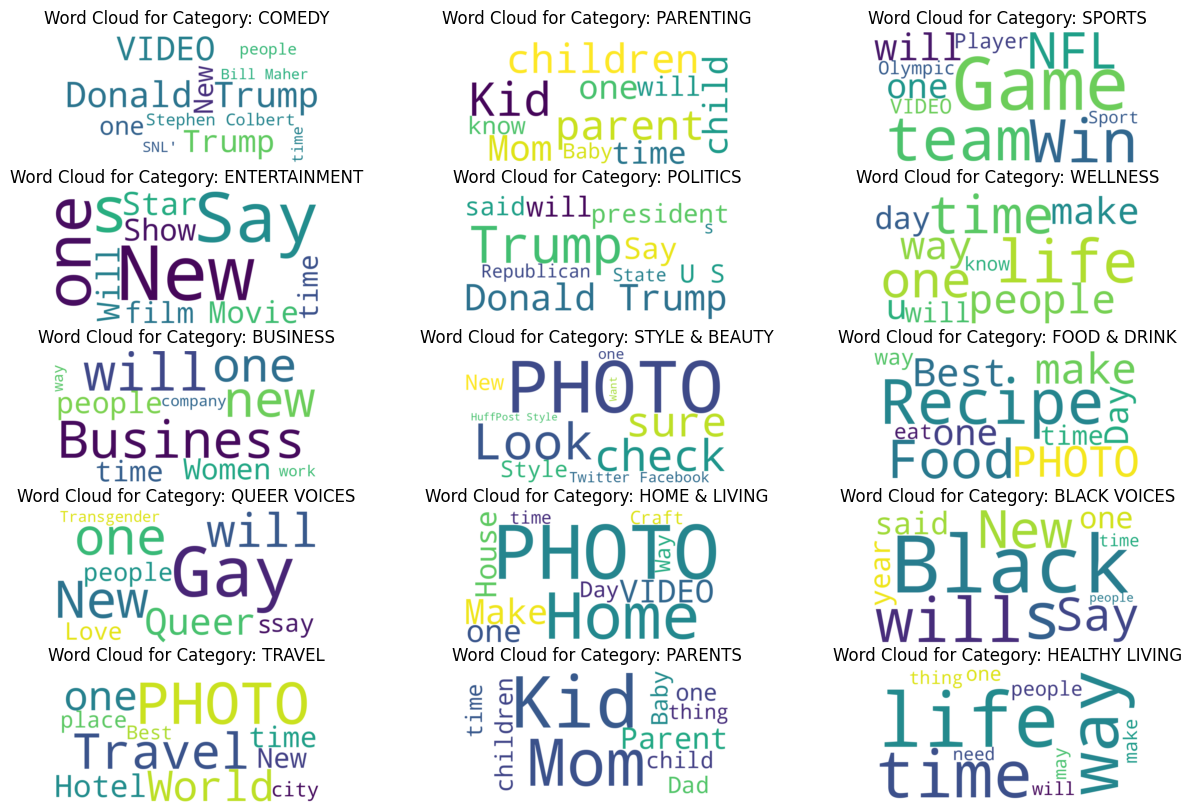

In [ ]:
df['raw_data'] = df['headline']+' '+df['short_description']

plt.figure(figsize=(15, 10))
categories = df['category'].unique()

for i,category in enumerate(categories):
    # Filter the DataFrame for the current category
    category_df = df[df['category'] == category]

    # Concatenate the text data for the current category
    text_data = ' '.join(category_df['raw_data'])

    # Generate a word cloud
    wordcloud = WordCloud(width=800, height=400, max_words=10, background_color='white').generate(text_data)

    # Display the word cloud for the current category
    plt.subplot(5,3,i+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Category: {category}')
    plt.axis('off')
plt.show()

#### Analysis of TF-IDF values

['dog' 'grownup' 'will' ... 'super bowl' 'bust' 'friday night']


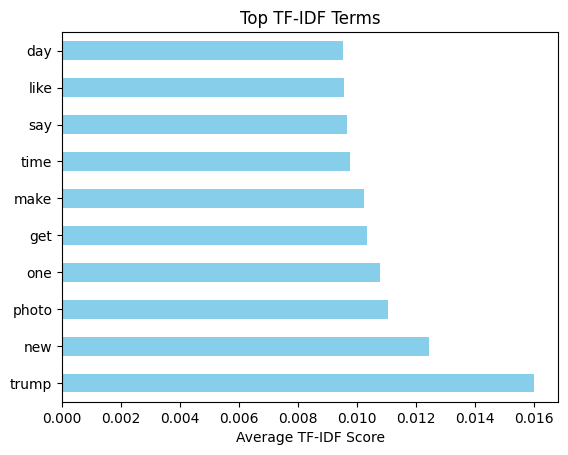

In [ ]:
# Vectorize all preprocessed data with TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,3))
tfidf_matrix = tfidf_vectorizer.fit_transform(df['data'].apply(join))

# Get feature names (terms)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Create a DataFrame for better visualization
tfidf_df = pd.DataFrame(data=tfidf_matrix.toarray(), columns=feature_names)

# Identify top TF-IDF terms for each document
top_tfidf_terms_per_doc = tfidf_df.idxmax(axis=1)
print(top_tfidf_terms_per_doc.to_numpy())

# Identify terms with the highest average TF-IDF across all documents
top_avg_tfidf_terms = tfidf_df.mean().nlargest(10)

# Visualize top TF-IDF terms
top_avg_tfidf_terms.plot(kind='barh', color='skyblue')
plt.title('Top TF-IDF Terms')
plt.xlabel('Average TF-IDF Score')
plt.show()

['dog' 'grownup' 'will' ... 'bowl' 'bust' 'teammat']


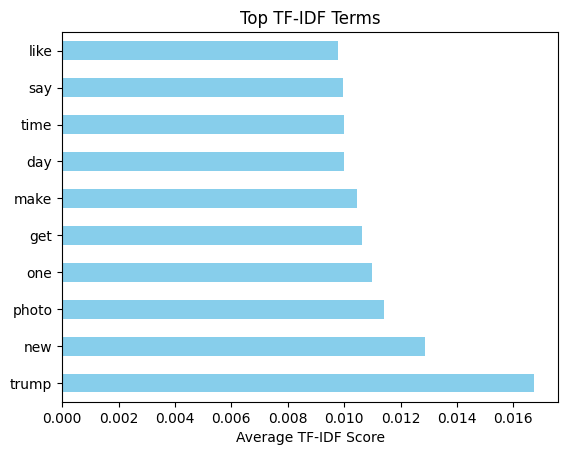

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

# Vectorize all preprocessed data with TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['data'].apply(join))

# Get feature names (terms)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Create a DataFrame for better visualization
tfidf_df = pd.DataFrame(data=tfidf_matrix.toarray(), columns=feature_names)

# Identify top TF-IDF terms for each document
top_tfidf_terms_per_doc = tfidf_df.idxmax(axis=1)
print(top_tfidf_terms_per_doc.to_numpy())

# Identify terms with the highest average TF-IDF across all documents
top_avg_tfidf_terms = tfidf_df.mean().nlargest(10)

# Visualize top TF-IDF terms
top_avg_tfidf_terms.plot(kind='barh', color='skyblue')
plt.title('Top TF-IDF Terms')
plt.xlabel('Average TF-IDF Score')
plt.show()

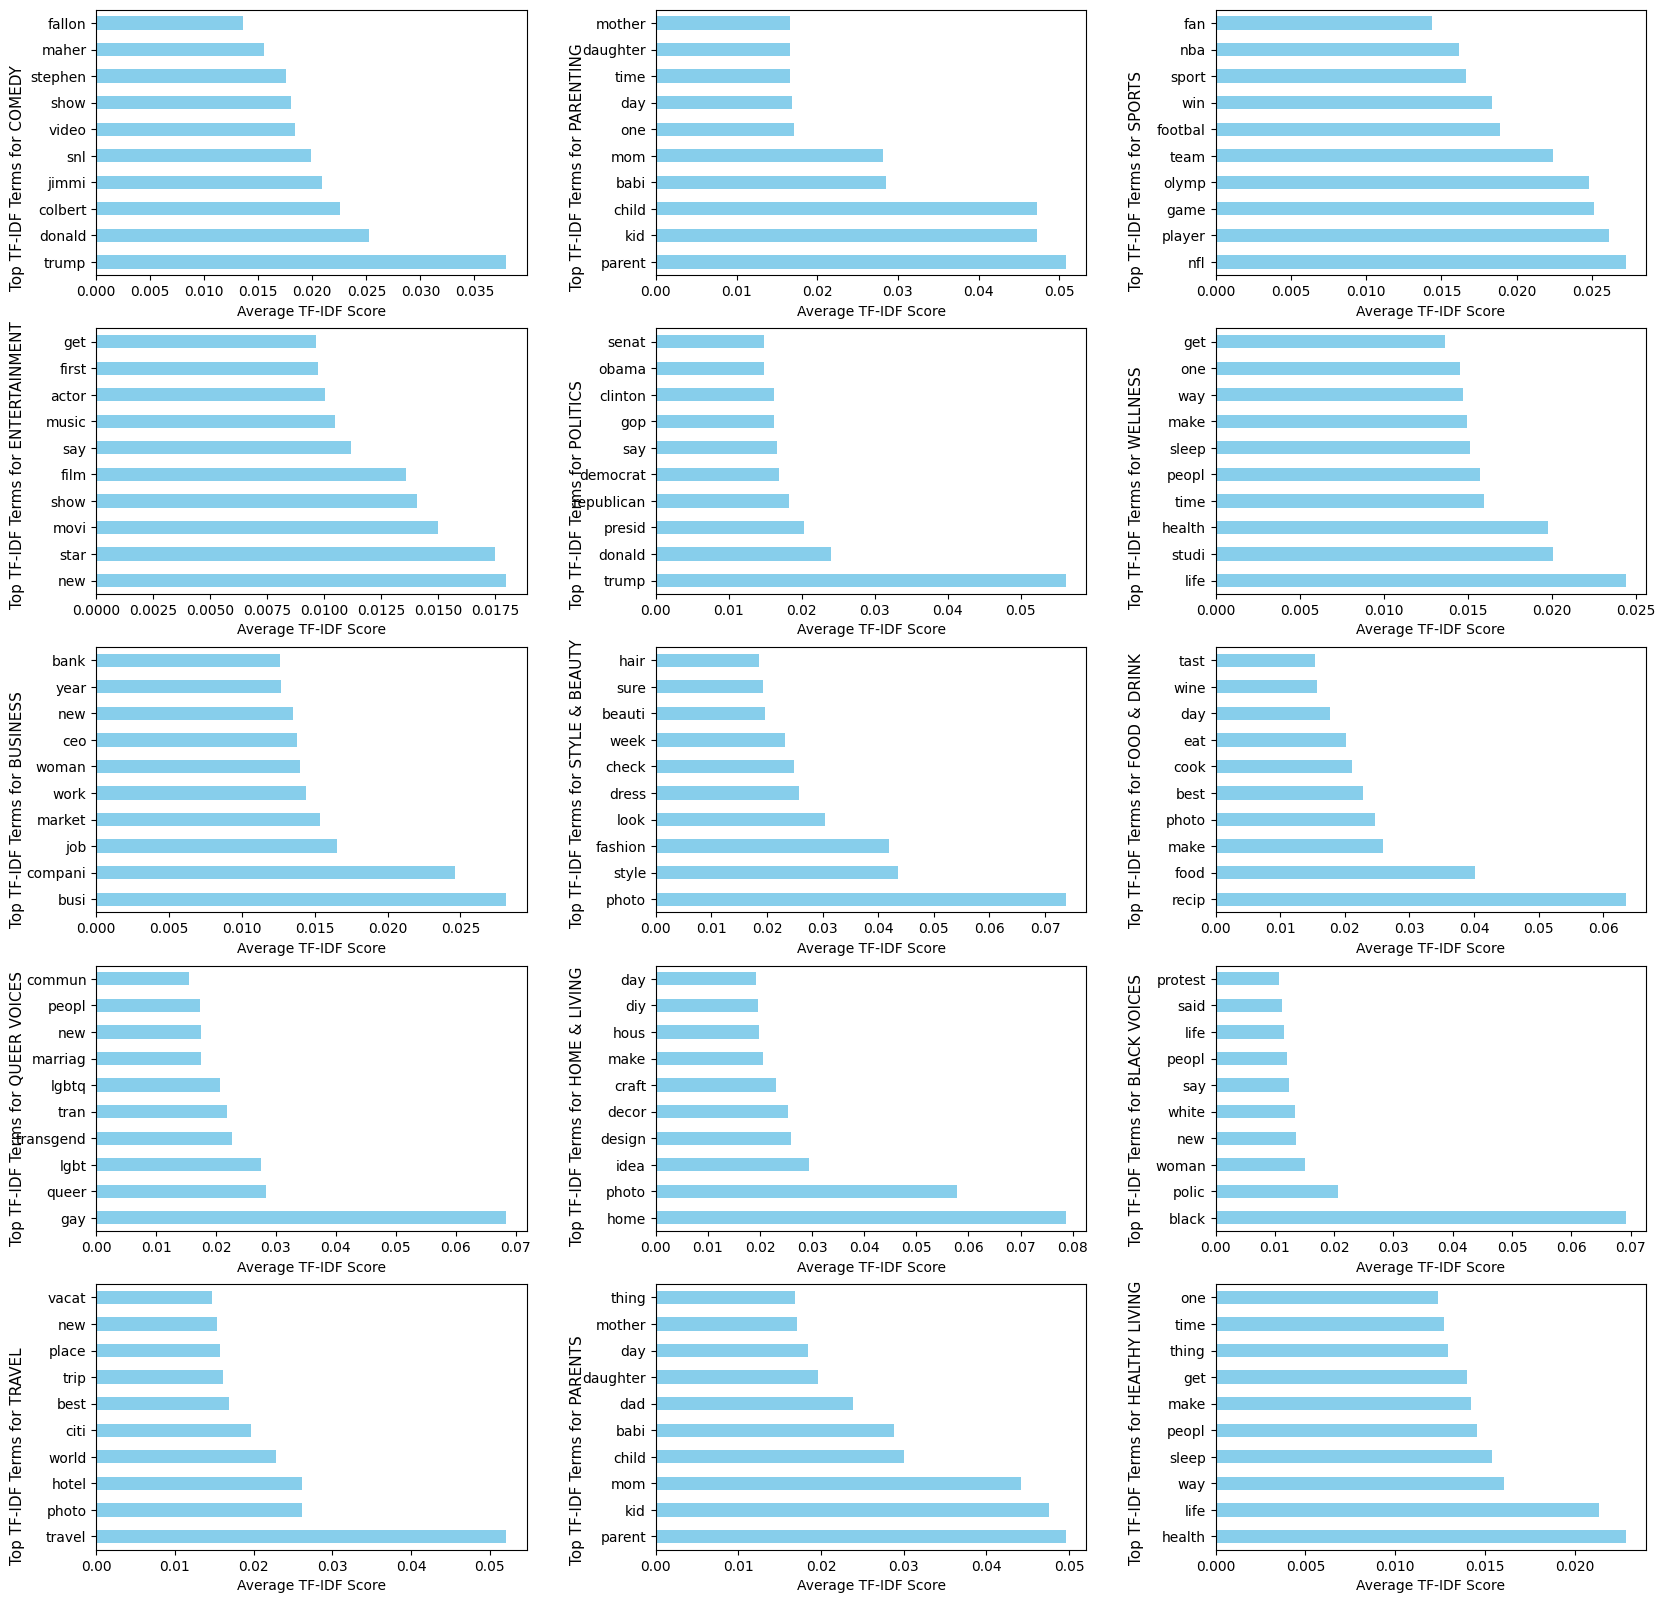

In [ ]:
categories = df['category'].unique()
plt.figure(figsize=(20,20))
plt.tight_layout()
for i,c in enumerate(categories):
  # Identify terms with the highest average TF-IDF across documents from specific category
  top_avg_tfidf_terms = tfidf_df.iloc[(df['category']==c).to_list()].mean()
  # Visualize top TF-IDF terms
  plt.subplot(5,3,i+1)
  top_avg_tfidf_terms.nlargest(10).plot(kind='barh', color='skyblue')
  plt.title('Top TF-IDF Terms for '+c,
            loc='left', x=-0.2, y=-0.15, pad=20, fontsize=11, rotation='vertical')
  plt.xlabel('Average TF-IDF Score')
plt.subplots_adjust(wspace=0.3)
plt.show()

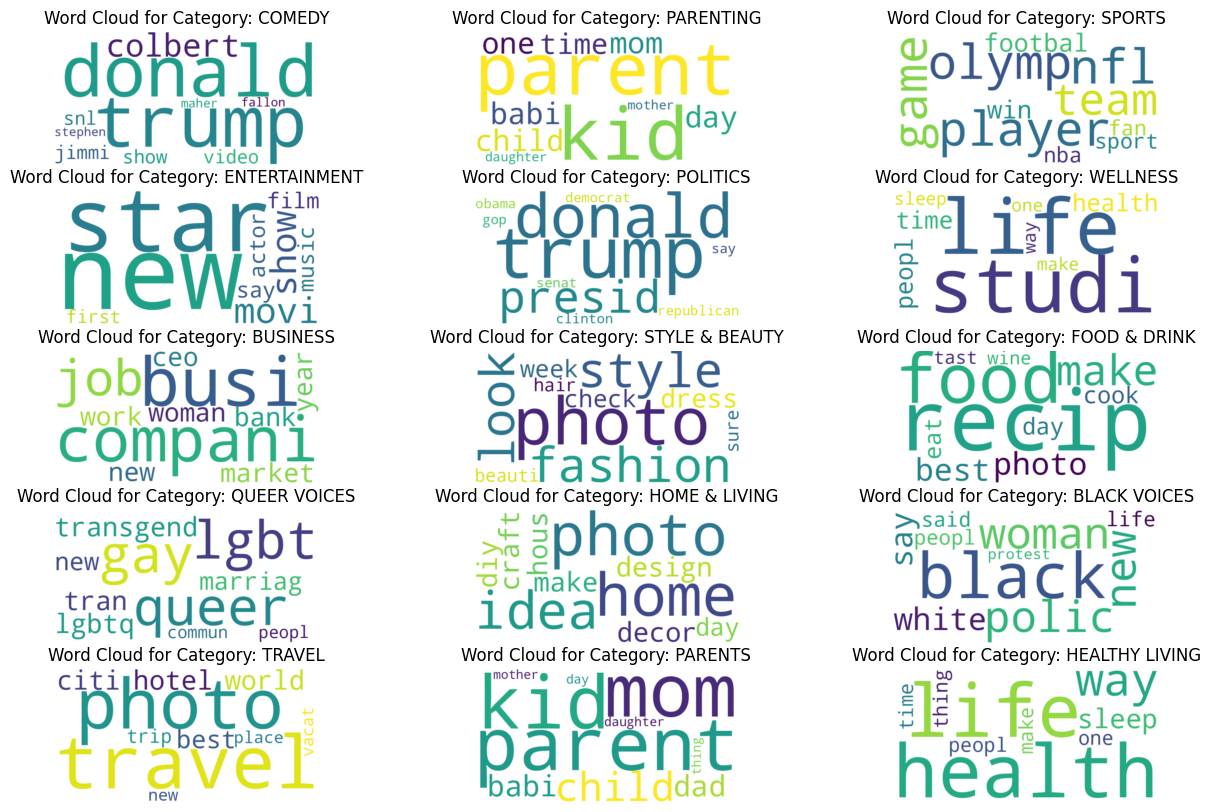

In [ ]:
categories = df['category'].unique()
plt.figure(figsize=(15,10))
plt.tight_layout()
for i,c in enumerate(categories):
  # Identify terms with the highest average TF-IDF across documents from specific category
  top_avg_tfidf_terms = tfidf_df.iloc[(df['category']==c).to_list()].mean()
  # Visualize top TF-IDF terms with a word cloud
  plt.subplot(5,3,i+1)
  wordcloud = (WordCloud(width=800, height=400, max_words=10, background_color='white')
     .generate(join(top_avg_tfidf_terms.nlargest(10).index)))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.title(f'Word Cloud for Category: {c}')
  plt.axis('off')
plt.subplots_adjust(wspace=0.3)
plt.show()

#### LexVec

In [ ]:
!wget https://www.dropbox.com/s/kguufyc2xcdi8yk/lexvec.enwiki%2Bnewscrawl.300d.W.pos.vectors.gz
!gunzip lexvec.enwiki+newscrawl.300d.W.pos.vectors.gz

--2024-01-13 17:48:02--  https://www.dropbox.com/s/kguufyc2xcdi8yk/lexvec.enwiki%2Bnewscrawl.300d.W.pos.vectors.gz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.66.18, 2620:100:6022:18::a27d:4212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.66.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/kguufyc2xcdi8yk/lexvec.enwiki%2Bnewscrawl.300d.W.pos.vectors.gz [following]
--2024-01-13 17:48:04--  https://www.dropbox.com/s/raw/kguufyc2xcdi8yk/lexvec.enwiki%2Bnewscrawl.300d.W.pos.vectors.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5377b7c5a3c03dcfbcc579d856.dl.dropboxusercontent.com/cd/0/inline/CLQqPq9hFCJdr8W1aoUIJsgbxHcBOJ5QbVTsAe7dDzDamiaOCOvACpgCd2JGyt_-S4yPrPB3h2hkApyWD8sBImXJdQ3JxFP50ryzHfuW9aUwJebv2lXpP-eDLh0WEGL1HYg/file# [following]
--2024-01-13 17:48:04--  https://uc5377b7c5a3c03dcfbcc579d856.dl.dropboxusercontent.com/cd/0/inline/CLQqPq9hFCJdr8W

In [ ]:
from gensim.models import KeyedVectors

# Load LexVec vectorizer
lexvec_model_path = 'lexvec.enwiki+newscrawl.300d.W.pos.vectors'
lexvec_model = KeyedVectors.load_word2vec_format(lexvec_model_path, binary=False)

In [ ]:
# Function for vectorization with LexVec
def lexVec_vectorize(ws):
  return np.array([lexvec_model[word] for word in ws if word in lexvec_model])

lexvec_vectors = X_rus['data'].apply(pipe(lexVec_vectorize,
                                       lambda x: np.mean(x,axis=0)))


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [ ]:
# Insert null vectors (where mean is undefined)
for i in range(lexvec_vectors.shape[0]):
  if lexvec_vectors.iloc[i].shape==():
    lexvec_vectors.iloc[i]=np.zeros(300)

#### t-SNE

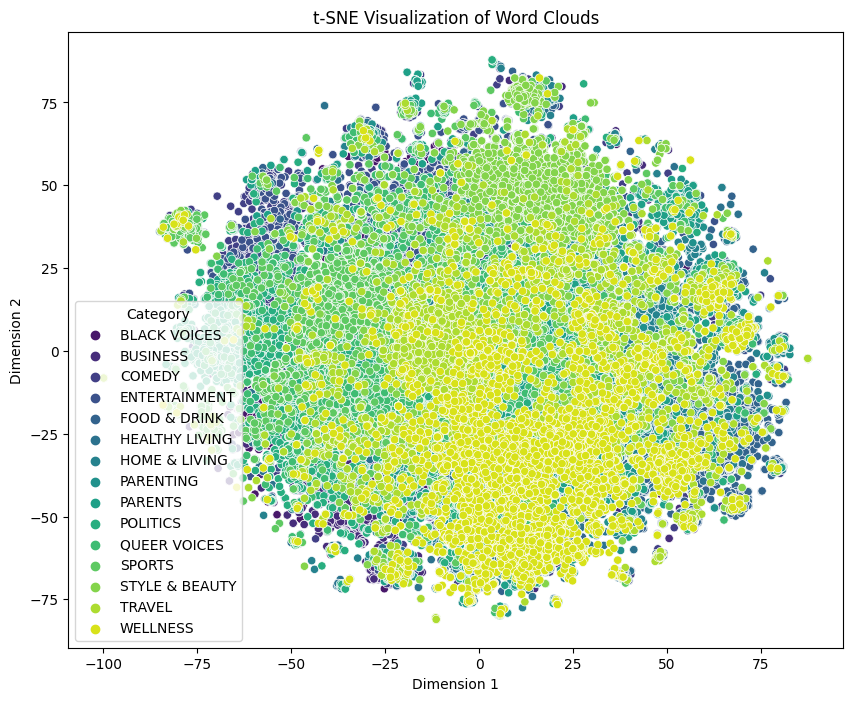

In [ ]:
# Perform t-SNE on the vectors
tsne_model = TSNE(n_components=2, random_state=42)
tsne_vectors = tsne_model.fit_transform(np.stack(
    lexvec_vectors.to_numpy()))

# Create a DataFrame for the t-SNE vectors
tsne_df = pd.DataFrame(tsne_vectors, columns=['Dimension 1', 'Dimension 2'])
tsne_df['Category'] = X_rus['category']  # Add category information to the DataFrame

# Plot the t-SNE visualization
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Dimension 1', y='Dimension 2', hue='Category', data=tsne_df, palette='viridis', legend='full')
plt.title('t-SNE Visualization of Word Clouds')
plt.show()

In [ ]:
# Perform t-SNE on the vectors
tsne_model3 = TSNE(n_components=3, random_state=42)
df_sample = random.sample(list(range(lexvec_vectors.shape[0])),1000)
tsne_vectors = tsne_model3.fit_transform(np.stack(
    lexvec_vectors.to_numpy()[df_sample]))

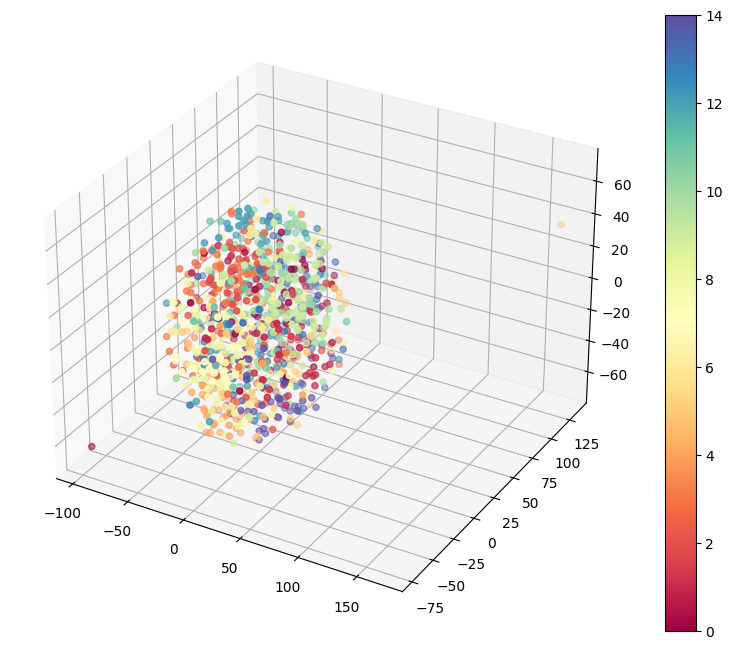

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create a DataFrame for the t-SNE vectors
tsne_df3 = pd.DataFrame(tsne_vectors, columns=['Dimension 1', 'Dimension 2', 'Dimension 3'])

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot points with colors based on labels
label_enc = LabelEncoder()
scatter = ax.scatter(tsne_df3.iloc[:, 0], tsne_df3.iloc[:, 1], tsne_df3.iloc[:, 2],
                     c=label_enc.fit_transform(X_rus['category'].iloc[df_sample]), cmap=plt.cm.Spectral)

# Add a colorbar
colorbar = plt.colorbar(scatter)

plt.show()

#### Hierarchical clustering

In [ ]:
from scipy.spatial.distance import pdist

# Take a sample
df_sample = random.sample(list(range(lexvec_vectors.shape[0])),10000)
# Create the linkage matrix
linkage_matrix = linkage(pdist(np.stack(lexvec_vectors.to_numpy()[df_sample])), method='ward')

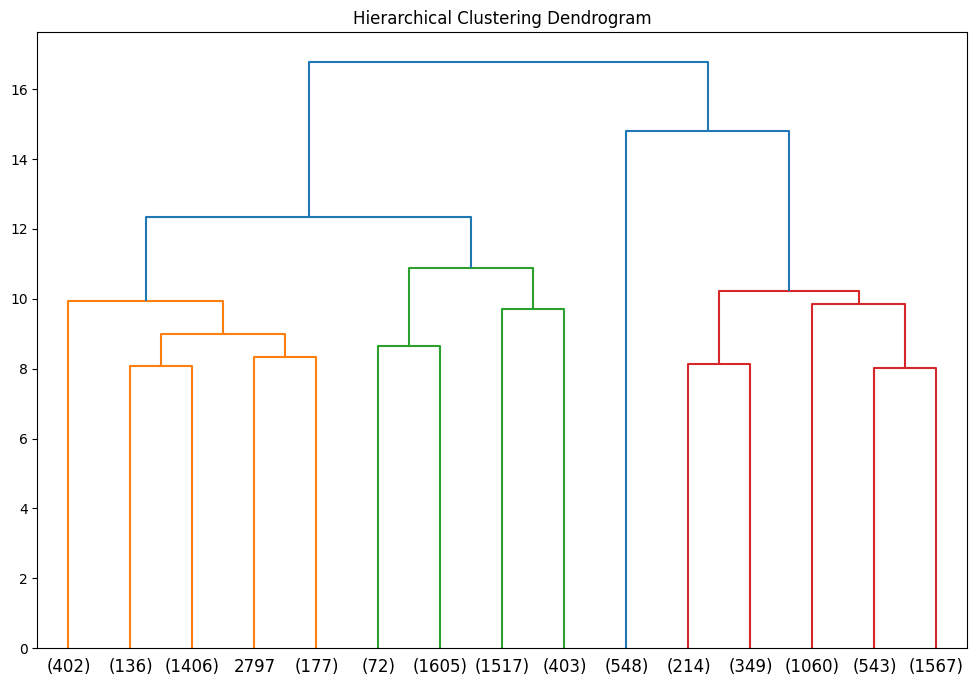

In [ ]:
# Visualize results with a dendrogram
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix,truncate_mode='lastp',p=15)
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

Analyze 15 clusters

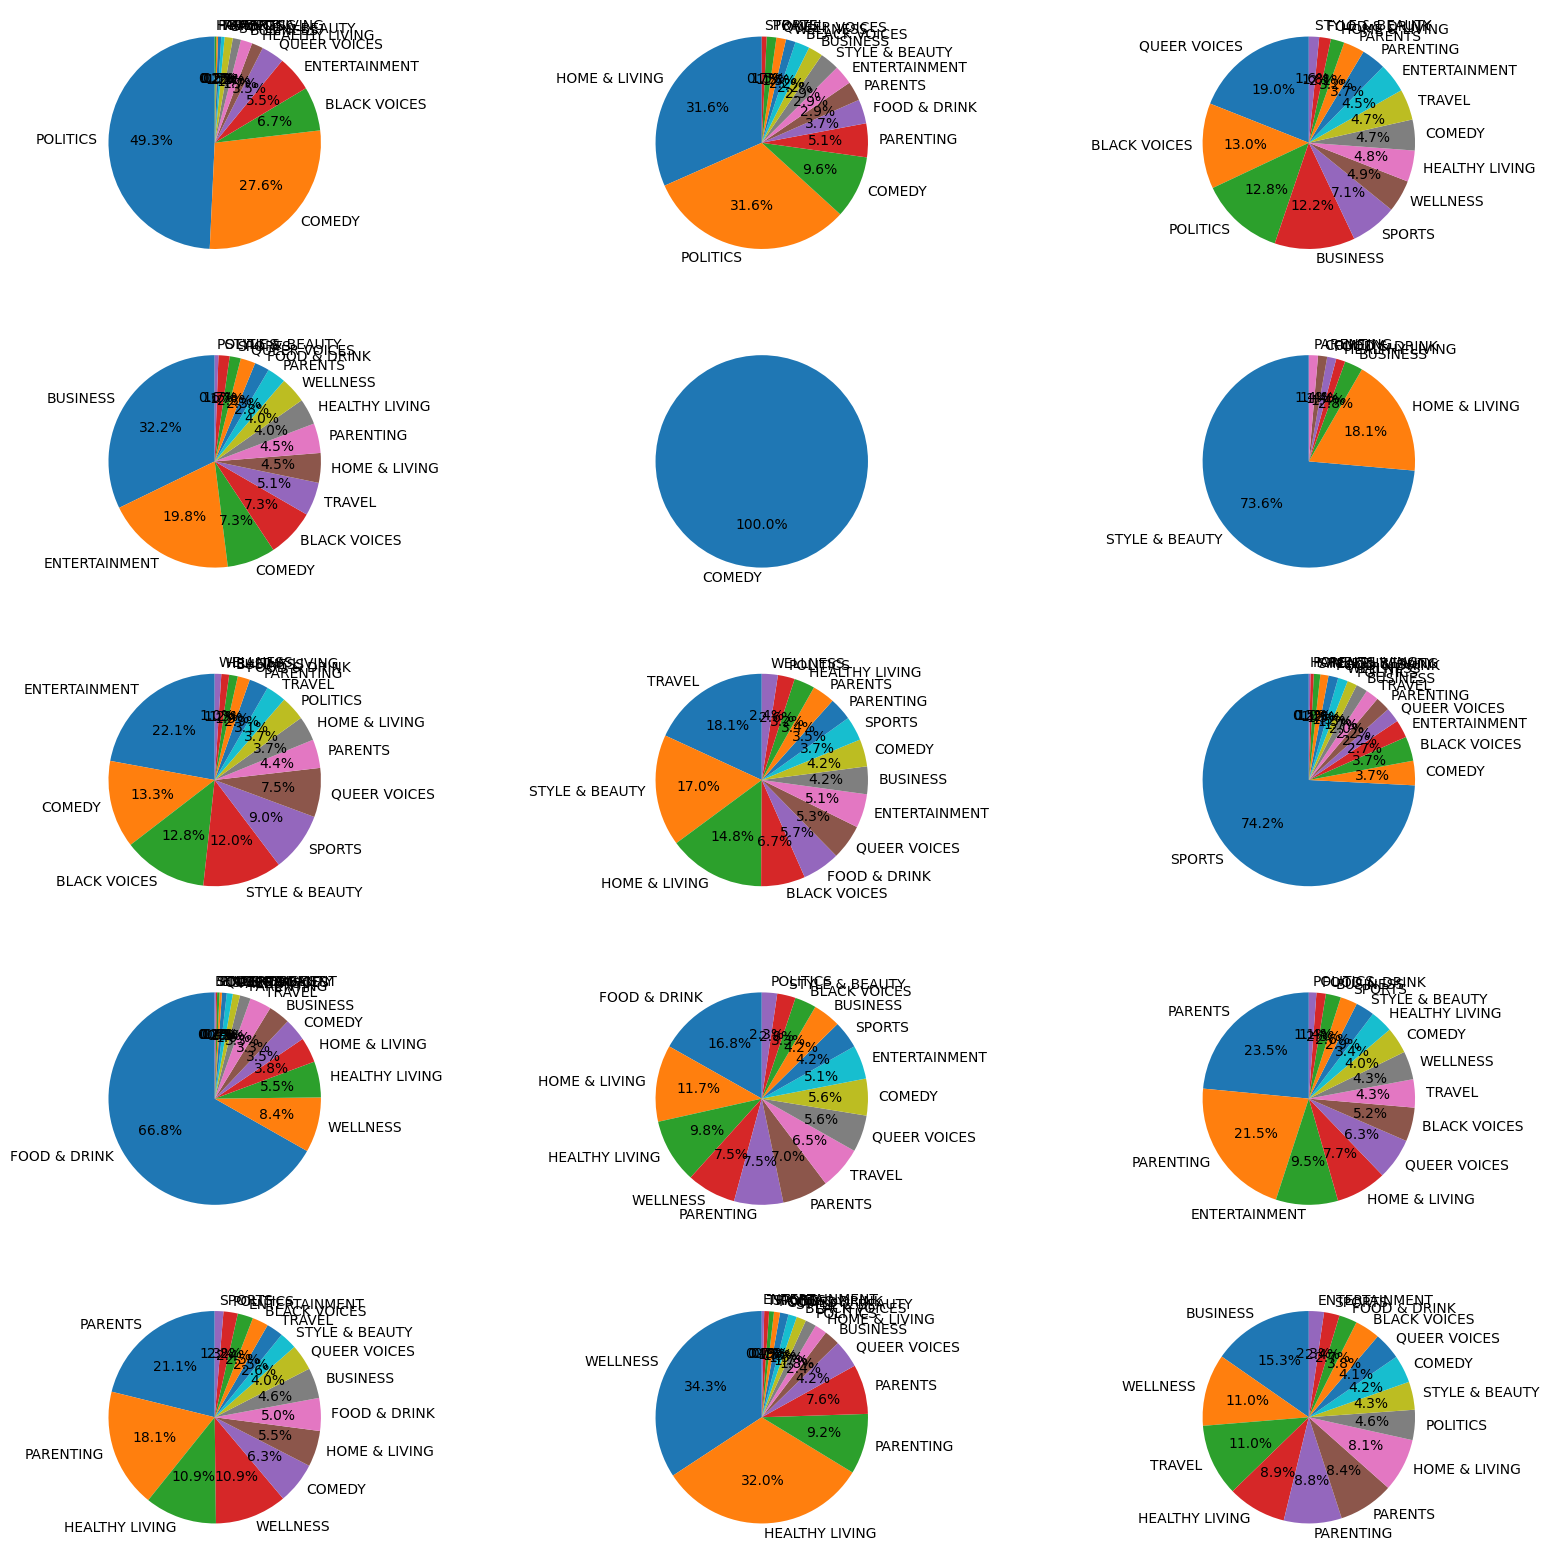

In [ ]:
from scipy.cluster.hierarchy import fcluster

# Get cluster membership (for 15 clusters)
clusts = fcluster(linkage_matrix, t=15, criterion='maxclust')

# Draw pie charts per cluster
plt.figure(figsize=(20, 20))
for i in range(15):
  plt.subplot(5,3,i+1)
  category_counts = X_rus.iloc[df_sample]['category'].iloc[clusts==i+1].value_counts()
  plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=90)
plt.show()

Analyzing the 4 clusters

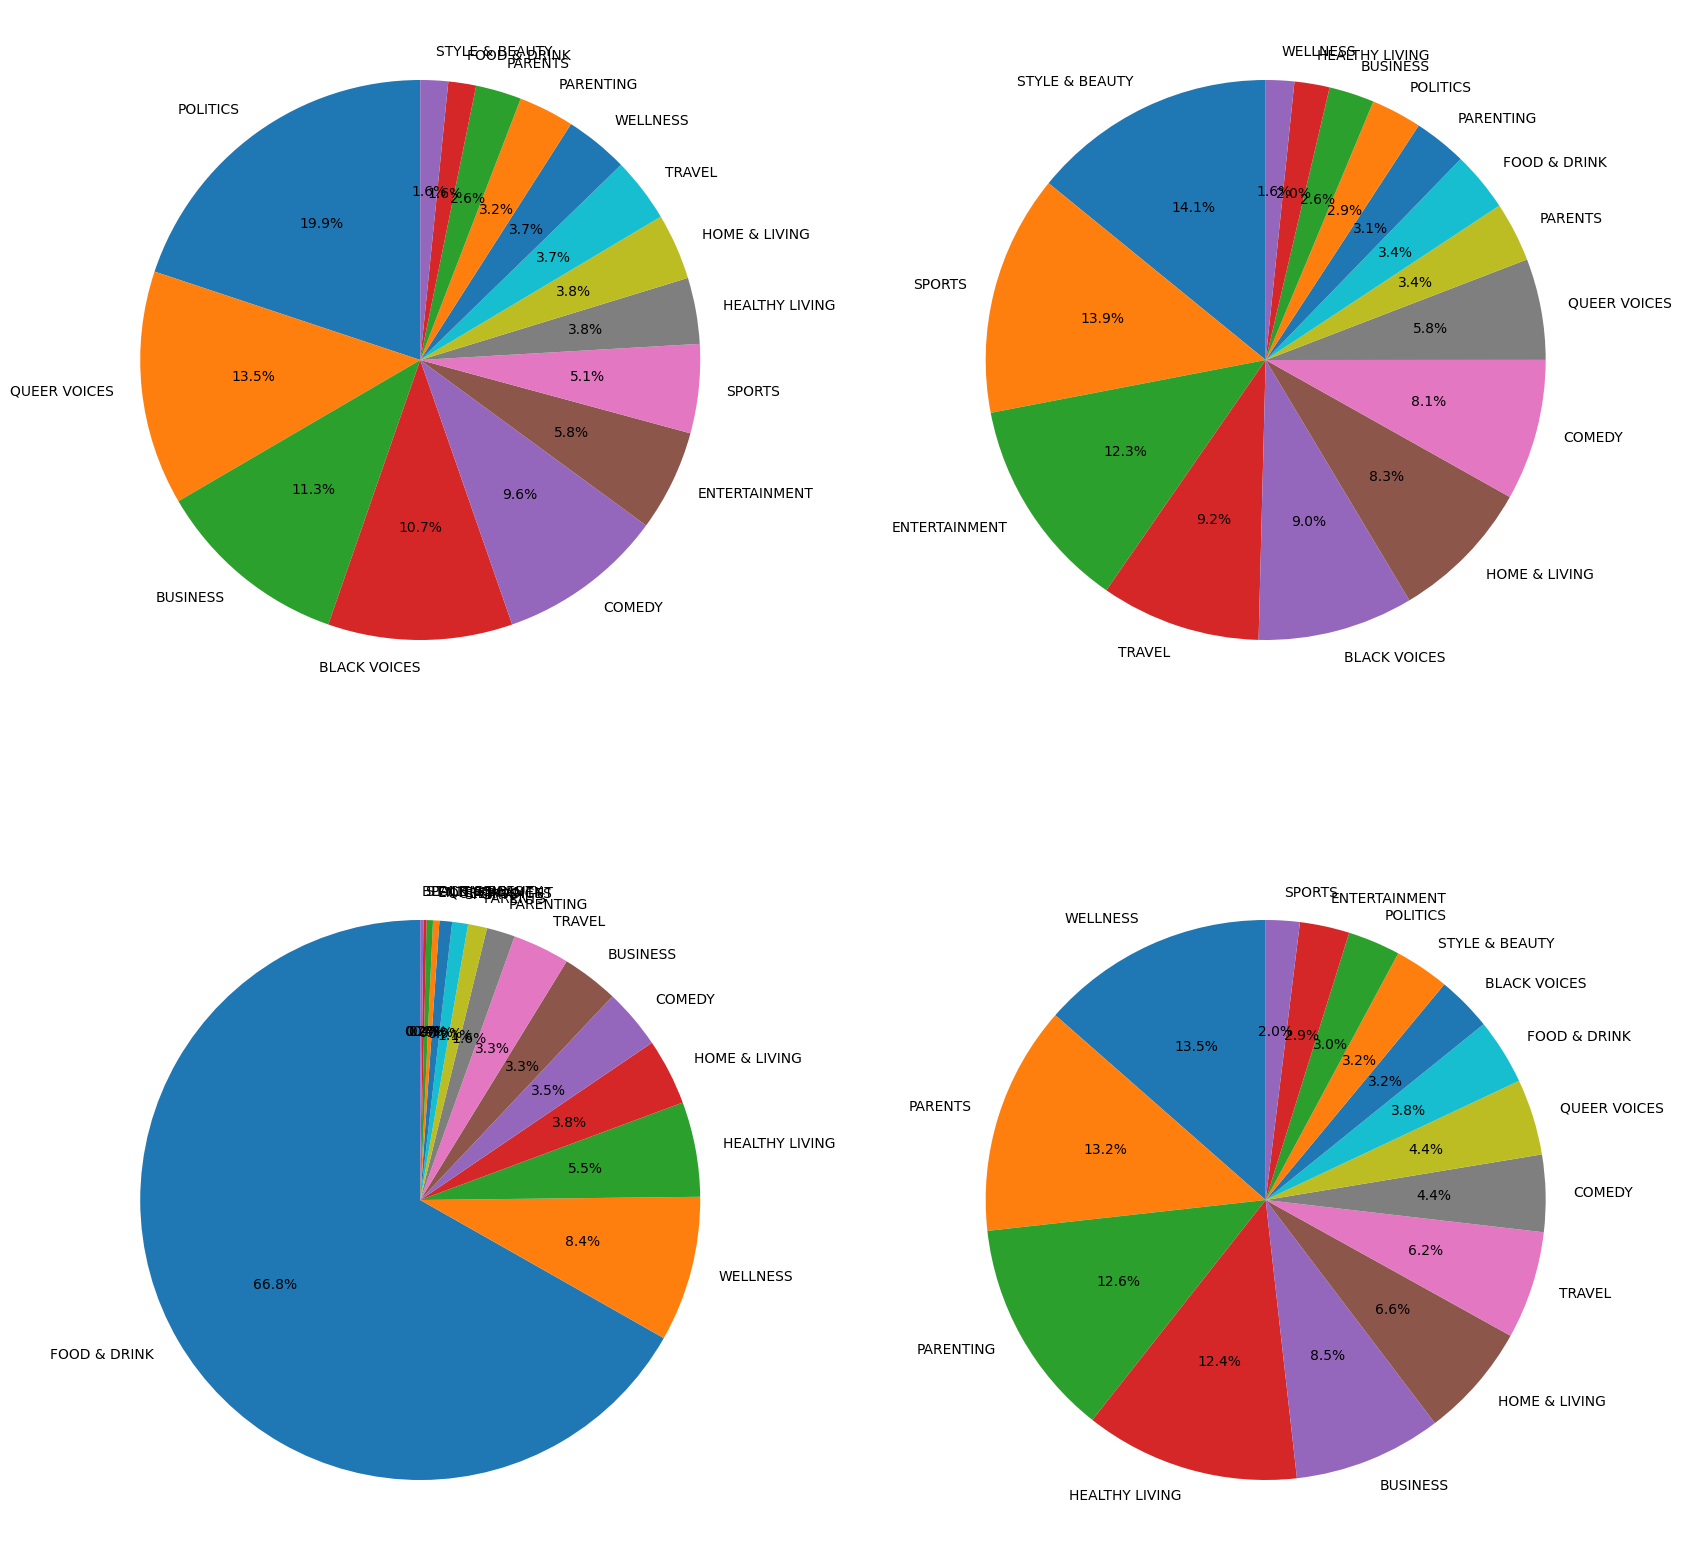

In [ ]:
# Get cluster membership (for 15 clusters)
clusts = fcluster(linkage_matrix, t=4, criterion='maxclust')

# Draw pie charts per cluster
plt.figure(figsize=(20, 20))
for i in range(4):
  plt.subplot(2,2,i+1)
  category_counts = X_rus.iloc[df_sample]['category'].iloc[clusts==i+1].value_counts()
  plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=90)
plt.show()

#### Dummy classifiers

In [ ]:
from sklearn.dummy import DummyClassifier
from imblearn.metrics import classification_report_imbalanced

rand_clf = DummyClassifier(strategy='stratified')
rand_clf.fit(df['data'], df['category'])
y_pred_rand = rand_clf.predict(df['data'])
print(classification_report_imbalanced(df['category'], y_pred_rand))

maj_clf = DummyClassifier(strategy='most_frequent')
maj_clf.fit(df['data'], df['category'])
y_pred_maj = maj_clf.predict(df['data'])
print(classification_report_imbalanced(df['category'], y_pred_maj))

### Modelling and evaluation

#### Implementation

Imports

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,top_k_accuracy_score
from sklearn.metrics import average_precision_score, brier_score_loss, recall_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import random
from imblearn.metrics import classification_report_imbalanced
import gc
from google.colab import files

General function for training and evaluation

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
import time

# Function for renaming columns and indexes to a readable format
def rename(s):
  return (s.replace('_',' ')
  .replace('&','and')
  .replace('rec','recall')
  .replace('pre','precision')
  .replace('spe','specificity')
  .replace('geo','geom. mean')
  .replace('iba','ind. bal. acc.')
  .replace('support','sup')
  .replace('sup','support'))

# Function that returns the "base" vectorization
def trueVect(x):
  if 'w2v' in x:
    return 'w2v'
  else:
    return 'tfidf'

# Function for adding vectorization to a model
def addVect(d,v,m):
  def f(x):
    # Get base vectorization
    tv = trueVect(v)
    if tv=='w2v':
      # Vectorize and scale accordingly
      if 'avg_w2v_scaled' in v:
        a = x.apply(avg_w2v(vect[joinu(d,tv,'vectorizer')]))
        b = vect[d+'_avg_w2v_scaler'].transform(np.stack(a.to_numpy()))
        c = m(regularize[v](b))
        return c
      if 'avg_w2v' in v:
        a = x.apply(avg_w2v(vect[joinu(d,tv,'vectorizer')]))
        c = m(regularize[v](a))
        return c
    else:
      return m(regularize[v](
          vect[joinu(d,tv,'vectorizer')].transform(mapc(join)(x))
      ))
  return f

# Return latex table
def get_table(inp,out):
  # Create report
  cru = pd.DataFrame(classification_report_imbalanced(
          inp,out,
          output_dict=True))
  # Rename columns
  cru.columns = [rename(c) for c in cru.columns]
  # Transpose table
  cru = cru.transpose()
  # Correct illegal elements
  cru.iloc[-7:-1,-1] = np.zeros(6)
  cru.iloc[-1,:-1] = np.zeros(6)
  # Rename new column
  cru.columns = [rename(c) for c in cru.columns]
  # Initialize styling
  styler = cru.style
  # Add background gradient (2x), set number of decimal places
  (styler.background_gradient(cmap='cividis',vmin=0,vmax=1,subset=pd.IndexSlice[styler.columns[:-1]])
  .background_gradient(cmap='inferno',vmin=0,vmax=cru.iloc[-1,-1],subset=pd.IndexSlice[styler.columns[-1]])
  .format(precision=4))
  # Convert to latex
  return styler.to_latex(
            clines="skip-last;data",
            convert_css=True,
            position_float="centering",
            multicol_align="|c|",
            hrules=True,)

model = {}
sanity_sample = df.sample(50000,random_state=42)
def train_eval(model_name='None',pmodel=None,vectorizations=[],samples=[],sampling=None, keepModel=False):
  global model
  bar = tqdm(total=len(samples)*len(vectorizations)*3,position=1,desc='Current progress')
  for d in samples:
    for v in vectorizations:
      if not keepModel:
        model={}
        gc.collect()
      # Show current operation
      bar.set_description(f'Current progress ({d}, {v})', refresh=True)
      # Save model
      model[joinu(d,v,model_name)] = pmodel
      # Sample if needed
      if not sampling is None:
        sample = np.array(random.sample(range((train[joinu(d,v)]).shape[0]),sampling))
      else:
        sample = np.array(range(regularize[v](train[joinu(d,v)]).shape[0]))
      # Fit model
      startFit = time.time()
      pmodel.fit(regularize[v](train[joinu(d,v)])[sample], np.array(train[joinu(d,'class')])[sample])
      endFit = time.time()
      bar.update()
      # Test model
      startTest = time.time()
      test[joinu(d,v,model_name,'pred')]=pmodel.predict(regularize[v](test[joinu(d,v)]))
      endTest = time.time()
      bar.update()
      # Create directory
      if not os.path.exists(model_name+'/'):
        os.mkdir(model_name)
      # Confusion matrix
      cm = confusion_matrix(test[joinu(d,'class')],test[joinu(d,v,model_name,'pred')],labels=pmodel.classes_)
      disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=pmodel.classes_)
      disp.plot(xticks_rotation='vertical')
      plt.title(join(['Confusion matrix for sample',d,'and vectorization',v]))
      plt.savefig(model_name+'/'+joinu(model_name,d,v,'confusion_matrix.png'), bbox_inches='tight')
      plt.clf()
      bar.update()
      # Generate report with execution time, best hyper-parameters and latex table report
      with open(model_name+'/'+joinu(model_name,d,v+'.txt'), 'w') as f:
        # Write execution time
        f.write(f'Fit time: {endFit-startFit}\n')
        f.write(f'Test time: {endTest-startTest}\n')
        scre = classification_report_imbalanced(
            sanity_sample['category'],
            addVect(d,v,pmodel.predict)(sanity_sample['data']),
            output_dict=True)
        f.write(f'Sanity check: avg f1: {scre["avg_f1"]:.4}, avg precision: {scre["avg_pre"]:.4}, avg recall: {scre["avg_rec"]:.4}\n')
        # Write hyper-parameters
        try:
          f.write(str(pmodel.best_params_))
        except:
          try:
            f.write(str(pmodel.C_))
          except:
            f.write('No params.')
        f.write('\n\n')
        # Write latex table
        f.write(get_table(test[joinu(d,'class')],
                          test[joinu(d,v,model_name,'pred')]))
  # Zip and download results
  zipName = model_name+'.zip'
  !zip -r $zipName $model_name
  files.download(zipName)
  return model

Models and parameters

In [ ]:
from sklearn.linear_model import RidgeClassifierCV, LogisticRegressionCV
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB, ComplementNB
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, AdaBoostClassifier

# Parameters for grid search
params = {}
params['svc'] = {
  'C':[0.1,1,10]
}

params['MultinomialNB'] = {
  'alpha':np.logspace(0,-9, num=50)
}

params['ComplementNB'] = {
  'alpha':np.logspace(0,-9, num=50)
}

# Models
model_settings = [('ridge',              # Name of the model
                    RidgeClassifierCV(), # Model code
                    ['avg_w2v'],         # Vectorizations used
                    samples,             # Samples used
                    117324),             # Additional sampling
                  ('logregression',
                    LogisticRegressionCV(),
                    ['avg_w2v'],
                    samples,
                    117324),
                  ('svc',
                    RandomizedSearchCV(svm.LinearSVC(),params['svc']),
                    ['tfidf'],
                    samples,
                    None),
                  ('MultinomialNB',
                    RandomizedSearchCV(MultinomialNB(),params['MultinomialNB']),
                    ['tfidf','avg_w2v_scaled'],
                    samples,
                    None),
                  ('GaussianNB',
                    GaussianNB(),
                    ['tfidf','avg_w2v_scaled'],
                    samples,
                    None),
                  ('ComplementNB',
                    RandomizedSearchCV(ComplementNB(),params['ComplementNB'],verbose=5),
                    ['tfidf','avg_w2v_scaled'],
                    samples,
                    None),
                  ('AdaBoostClassifier',
                    AdaBoostClassifier(random_state=42),
                   ['tfidf','avg_w2v'],
                    samples,
                    None),
                  ('RandomForestClassifier',
                    RandomForestClassifier(max_depth=10,random_state=42),
                    ['tfidf','avg_w2v'],
                    samples,
                    None)
                    ]


#### Train and evaluate

In [ ]:
report={}
pbarglob = tqdm(total=len(model_settings),position=0,desc='Total progress')
for model_name,pmodel,vectorizations,samp,sampling in model_settings:
  train_eval(pmodel=pmodel,
             model_name=model_name,
             vectorizations=vectorizations,
             samples=samp,
             sampling=sampling)
  pbarglob.update()
pbarglob.close()

Total progress:   0%|          | 0/5 [00:00<?, ?it/s]

Current progress:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
